This is a short experiment implementing DeepMind's A3C algorithm to solve the traffic lights problem. The implementation is by no means meant to be original, instead draws for different versions available online.

The concrete statement of the traffic lights problems is as follows:

Suppose you are a path which contain a number $lights$ of traffic lights, each of which displays a random amount of time $time\_left$, uniformily distributed on the interval $[0, time]$ to be waited to before you may cross. Suppose additionally that the time displayed in each of the lights is independent form the others. In your pocession you have a device that allows you to skip a number $uses$ of lights.
Given that you use the optimal strategy, what is the expected amount of waiting time on the whole path?

Using the independence of the traffic lights it is quite easy to derive a recursive formula for the optimal strategy. The goal of the present experiment is to answer the question: "can a neural network learn the optimal strategy from experience?"

At it's present state, our agent manages to attain around 80%+ of the optimal performance, however, the training is not stable, some lucky runs might see performances above 96% and some unlucky runs can see the agent performing no better than random choice.
Current work is being done to implement a recurent version of this algorithm in hopes to improve stability

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

import threading
import numpy as np
# set the random seed
#np.random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import RMSprop
from keras.regularizers import l2
from keras import backend as K

Using TensorFlow backend.


In [2]:
# global variables for threading
episode = 0
scores = []

# settings regarting the actor-critic network
EPISODES = 100000
ENTROPY_FACTOR = 0.025
LEARNING_RATE = 0.000005
CRITIC_FACTOR = 1
DISCOUNT = 0.9
HIDDEN_1_SIZE = 64
HIDDEN_2_SIZE = 128
HIDDEN_3_SIZE = 512
THREADS = 8
ALPHA = 0.0001

# settings for the traffic lights enviroment to be used for training
MAX_LIGHTS = 25  # max number of lights if this is allowed to be random
LIGHTS= 10  # number of lights, set to None for random
USES = None  # number of times on can skip a light, set to None for random
TIME = 100  # maximum waiting time at each light

In [3]:
def estimated_time_recursion(lights, uses, time=TIME):
    """This is the recursive solution"""
    if lights == 0:
        return 0
    elif uses == 0:
        return lights*time/2
    elif lights <= uses:
        return 0
    else:
        a = estimated_time_recursion(lights - 1, uses - 1, time)
        return a - (1/(2*time))*(a - estimated_time_recursion(lights - 1, uses, time))**2

In [4]:
class TrafficLightsProblem:
    """Enviroment for the traffic lights problem 
    following the template from OpenAI Gym 
    """
    def __init__(self, lights=LIGHTS, uses=USES):
        if lights is None:
            self.lights = np.random.randint(low=2, high=MAX_LIGHTS + 1)
        else:
            self.lights = lights

        if uses is None:
            self.uses = np.random.randint(low=1, high=self.lights)
        else:
            self.uses = uses

        self.time_left = np.random.randint(low=0, high=TIME + 1)
        
        self.total_time = 0

    def reset(self, lights=LIGHTS, uses=USES):
        if lights is None:
            self.lights = np.random.randint(low=2, high=MAX_LIGHTS + 1)
        else:
            self.lights = lights

        if uses is None:
            self.uses = np.random.randint(low=1, high=self.lights)
        else:
            self.uses = uses
        
        self.total_time = 0
        self.time_left = np.random.randint(low=0, high=TIME + 1)
        return np.array([self.lights, self.uses, self.time_left])

    def step(self, action=0):
        self.lights -= 1
        reward = 0
        
        if action == 1 and self.uses > 0:
            self.uses -= 1
            reward = self.time_left  #if the agent uses the device, we reward it with the time it saved
        else:
            self.total_time += self.time_left
        
        if self.uses <= 0:
            self.total_time += sum(np.random.randint(low=0, high=TIME + 1) for i in range(self.lights))
            self.lights = 0
        elif self.uses >= self.lights:
            self.lights = 0
        
        self.time_left = np.random.randint(low=0, high=TIME + 1) if self.lights > 0 else 0
        
        if self.lights == 0:
            reward += -self.total_time  # by the end of the game, we penalize the agent with the total time

        return [np.array([self.lights, self.uses, self.time_left]), reward, self.lights == 0, {}]

    def state(self):
        return np.array([self.lights, self.uses, self.time_left])

In [5]:
class A3CAgent:
    """A3C agent addapted for our enviroment """
    def __init__(self, state_size, action_size):
        # size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Hyper parameters as defined in the settings
        self.actor_lr = LEARNING_RATE
        self.critic_lr = CRITIC_FACTOR*LEARNING_RATE
        self.discount_factor = DISCOUNT
        self.hidden1, self.hidden2 = HIDDEN_1_SIZE, HIDDEN_2_SIZE
        self.entropy_factor = ENTROPY_FACTOR
        self.threads = THREADS

        # create model for actor and critic network
        self.actor, self.critic = self.build_model()

        # method for training actor and critic network
        self.optimizer = [self.actor_optimizer(), self.critic_optimizer()]

        self.sess = tf.InteractiveSession()
        K.set_session(self.sess)
        self.sess.run(tf.global_variables_initializer())

    # actor -> state is input and probability of each action is output of network
    # critic -> state is input and value of state is output of network
    # actor and critic network share first hidden layer
    def build_model(self):
        state = Input(batch_shape=(None,  self.state_size))
        shared_1 = Dense(self.hidden1, input_dim=self.state_size, activation='relu', kernel_initializer='glorot_uniform')(state)
        shared_2 = Dense(self.hidden1, input_dim=self.state_size, activation='relu', kernel_initializer='glorot_uniform')(shared_1)
        shared_f = Dense(self.hidden2, input_dim=self.state_size, activation='relu', kernel_initializer='glorot_uniform')(shared_2)

        actor_hidden = Dense(HIDDEN_3_SIZE, activation='relu', kernel_initializer='glorot_uniform')(shared_f)
        action_prob = Dense(self.action_size, activation='softmax', kernel_initializer='glorot_uniform')(actor_hidden)

        value_hidden = Dense(HIDDEN_3_SIZE, activation='relu', kernel_initializer='he_uniform')(shared_f)
        state_value = Dense(1, activation='linear', kernel_initializer='he_uniform')(value_hidden)

        actor = Model(inputs=state, outputs=action_prob)
        critic = Model(inputs=state, outputs=state_value)

        actor._make_predict_function()
        critic._make_predict_function()

        actor.summary()
        critic.summary()

        return actor, critic

    # loss function for Policy Gradient
    # added entropy to encourage exploration
    def actor_optimizer(self):
        action = K.placeholder(shape=(None, self.action_size))
        advantages = K.placeholder(shape=(None, ))

        policy = self.actor.output

        good_prob = K.sum(action * policy, axis=1)
        eligibility = K.log(good_prob + 1e-10) * K.stop_gradient(advantages)
        loss = -K.sum(eligibility)

        entropy = K.sum(policy * K.log(policy + 1e-10), axis=1)

        actor_loss = loss + self.entropy_factor*entropy

        optimizer = RMSprop(lr=self.actor_lr)
        updates = optimizer.get_updates(self.actor.trainable_weights, [], actor_loss)
        train = K.function([self.actor.input, action, advantages], [], updates=updates)
        return train

    # loss function for Value approximation
    def critic_optimizer(self):
        discounted_reward = K.placeholder(shape=(None, ))

        value = self.critic.output

        loss = K.mean(K.square(discounted_reward - value))

        optimizer = RMSprop(lr=self.critic_lr)
        updates = optimizer.get_updates(self.critic.trainable_weights, [], loss)
        train = K.function([self.critic.input, discounted_reward], [], updates=updates)
        return train

    # generate the separate agents for training
    def train(self):
        agents = [Agent(i, self.actor, self.critic, self.optimizer, self.discount_factor,
                        self.action_size, self.state_size) for i in range(self.threads)]

        for agent in agents:
            agent.start()
            
        for agent in agents:
            agent.join()
            
        scores_pd = pd.DataFrame(scores)    
        rolling = scores_pd.rolling(window=50,center=False).mean()
        ax_scores = scores_pd.plot(alpha=0.3, legend=False)
        rolling.plot(ax=ax_scores, legend=False)
        plt.show()


In [6]:
class Agent(threading.Thread):
    """agent class for threading """
    def __init__(self, index, actor, critic, optimizer, discount_factor, action_size, state_size):
        threading.Thread.__init__(self)

        self.states = []
        self.rewards = []
        self.actions = []

        self.index = index
        self.actor = actor
        self.critic = critic
        self.optimizer = optimizer
        self.discount_factor = discount_factor
        self.action_size = action_size
        self.state_size = state_size

    # thread interacting with environment
    def run(self):
        global episode
        env = TrafficLightsProblem()
        while episode < EPISODES:
            state = env.reset()
            score = 0
            normalizator = TIME*(env.lights - env.uses)/2
            while True:
                action = self.get_action(state)
                next_state, reward, done, _ = env.step(action)
                score += reward/(normalizator)

                self.memory(state, action, reward/normalizator)

                state = next_state

                if done:
                    episode += 1
                    #print("episode: ", episode, "/ score : ", score)
                    scores.append(score)
                    
                    self.train_episode(False)
                    break

    def discount_rewards(self, rewards, done=True):
        discounted_rewards = np.zeros_like(rewards)
        running_add = 0
        if not done:
            running_add = self.critic.predict(np.reshape(self.states[-1], (1, self.state_size)))[0]
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * self.discount_factor + rewards[t]
            discounted_rewards[t] = running_add
        return discounted_rewards

    # save <s, a ,r> of each step
    def memory(self, state, action, reward):
        self.states.append(state)
        act = np.zeros(self.action_size)
        act[action] = 1
        self.actions.append(act)
        self.rewards.append(reward)

    # update policy and value networks after every episode
    def train_episode(self, done):
        discounted_rewards = self.discount_rewards(self.rewards, done)

        values = self.critic.predict(np.array(self.states))
        values = np.reshape(values, len(values))

        advantages = discounted_rewards - values

        self.optimizer[0]([self.states, self.actions, advantages])
        self.optimizer[1]([self.states, discounted_rewards])
        self.states, self.actions, self.rewards = [], [], []

    def get_action(self, state):
        policy = self.actor.predict(np.reshape(state, [1, self.state_size]))[0]
        return np.random.choice(self.action_size, 1, p=policy)[0]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
Total params: 79,810
Trainable params: 79,810
Non-trainable params: 0
_________________________________________________________________
______

Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/beren/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1350, in _do_call
    return fn(*args)
  File "/home/beren/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1329, in _run_fn
    status, run_metadata)
  File "/home/beren/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 473, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.NotFoundError: FetchOutputs node IsVariableInitialized/IsVariableInitialized_3/IsVariableInitialized_41:0: not found

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/beren/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "<ipython-input-6-5934bb4ab461>", line 27, in run
    action = self.get_action(state)
  File "<ipython-input-6-

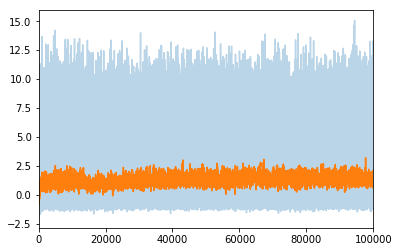

In [7]:
state_size = 3
action_size = 2
global_agent = A3CAgent(state_size, action_size)
global_agent.train()

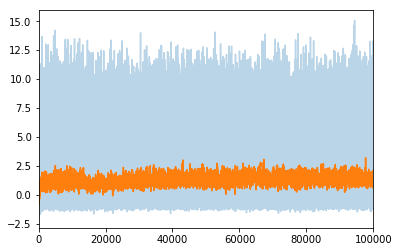

In [8]:
scores_pd = pd.DataFrame(scores)    
rolling = scores_pd.rolling(window=50,center=False).mean()
ax_scores = scores_pd.plot(alpha=0.3, legend=False)
rolling.plot(ax=ax_scores, legend=False)
plt.show()

In [10]:
# to evaluate the model, we let it play the game under fixed conditions
# and compare the performance with our recursive formula

game = TrafficLightsProblem()

results = []
test_lights = 10
test_uses = 5
print('Begining Simulation...')

for i in range(2000):
    state = game.reset(lights=test_lights, uses=test_uses)
    done = False
    actions =[]
    while done is not True:
        action = 0
        if state[0] > 0:
            policy = global_agent.actor.predict(np.reshape(state, [1, state_size]))[0]
            action = np.argmax(policy)
            if i % 100 == 0:
                actions.append((action, state[2]))
        state, reward, done, _ = game.step(action)
    results.append(game.total_time)
    if i % 100 == 0:
        print(actions)

print('actor done')

result = sum(results)/len(results)
target = estimated_time_recursion(test_lights, test_uses)
worst_case = TIME*(test_lights - test_uses)/2
performance = 100*(result - worst_case)/(target - worst_case)

print('MC mean: ', result, ', Recursion Formula:',  target)
print('Performance: ', performance)

Begining Simulation...
[(1, 73), (1, 78), (1, 99), (0, 35), (0, 89), (1, 61), (0, 14), (1, 93)]
[(0, 17), (1, 65), (1, 66), (1, 100), (0, 12), (1, 73), (0, 15), (1, 68)]
[(0, 31), (1, 85), (1, 55), (1, 71), (0, 31), (0, 44), (0, 0), (1, 13), (1, 28)]
[(1, 61), (0, 18), (1, 85), (0, 24), (1, 40), (0, 34), (1, 55), (1, 87)]
[(0, 27), (1, 93), (0, 34), (0, 14), (1, 70), (0, 10), (1, 95), (1, 77), (1, 100)]
[(1, 79), (1, 77), (0, 11), (0, 58), (1, 65), (0, 7), (0, 0), (1, 92), (1, 23)]
[(0, 4), (0, 15), (1, 62), (1, 92), (0, 28), (1, 78), (1, 50), (0, 5), (0, 12)]
[(0, 24), (1, 84), (1, 72), (1, 98), (0, 49), (0, 39), (1, 69), (1, 82)]
[(1, 64), (0, 12), (0, 0), (0, 26), (1, 21), (1, 71), (1, 57), (1, 78)]
[(1, 100), (0, 66), (0, 38), (0, 28), (1, 45), (1, 74), (1, 49), (0, 22), (1, 35)]
[(1, 67), (0, 63), (0, 10), (1, 86), (0, 9), (1, 58), (1, 82), (0, 15), (1, 96)]
[(1, 96), (0, 5), (1, 53), (0, 8), (0, 38), (1, 73), (0, 14), (0, 4)]
[(0, 28), (0, 13), (1, 30), (0, 15), (1, 92), (0, 9), 